# Intro

This database was downloaded from https://www.kaggle.com/thoughtvector/podcastreviews. It contains over a million reviews for 50k podcasts and is being updated monthly. The data was obtained by scraping iTunes podcast review RSS feeds https://rss.itunes.apple.com/.

It consists of 4 tables:

- **Categories** {podcast_id, category} (Each podcast may have one or multiple categories associated with it)
- **Podcasts** {podcast_id, itunes_id, slug. itunes_url, title} (We'll only keep podcast_id and title)
- **Reviews** {podcast_id, title, content, rating, author_id, created_at}
- **Runs** {run_at, max_rowid, reviews_added} (Tracks monthly uploads of the podcast data, we won't be using this.)

The only collaberator listed for this dataset is 
Stuart Axelbrooke. I found the actual scraper used to retrieve this data on his GitHub https://github.com/soaxelbrooke/app-store-scraper

Another important point I came across is that the rating average is specific to a country or region. So if a listener rates or posts a review with a US Apple ID, that review or rating is only visible to other users in the US. Axelbrooke's scraper is using a US id, so these ratings only take into account users in the US.

# Setup

In [1]:
%load_ext lab_black

In [89]:
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
from statsmodels.stats import weightstats as stests

In [3]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize": (9, 7.5)})

In [4]:
conn = sql.connect("data/podcast_review_db.sqlite")

# Data Cleaning

In [5]:
def duplicate_and_na(df: pd.DataFrame) -> str:
    """Returns count of duplicates and NA values in a DataFrame"""
    return df.duplicated().sum(), df.isna().sum()


def plot_barchart(
    series: pd.Series, x_label: str, y_label: str, title: str, horizontal: bool = False
) -> None:
    """Plots a barchart from a Series"""
    if horizontal:
        sns.barplot(x=series.values, y=series.index)
        plt.xlabel(y_label, size=15)
        plt.ylabel(x_label, size=15)
    else:
        sns.barplot(x=series.index, y=series.values)
        plt.xlabel(x_label, size=15)
        plt.ylabel(y_label, size=15)
    plt.title(title, size=20)

In [6]:
category = pd.read_sql("SELECT * FROM categories", conn)
category.head(1)

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts


In [7]:
duplicate_and_na(category)

(0,
 podcast_id    0
 category      0
 dtype: int64)

In [8]:
podcast = pd.read_sql("SELECT podcast_id, title podcast_name FROM podcasts", conn)
podcast.head(1)

,podcast_id,podcast_name
0,a00018b54eb342567c94dacfb2a3e504,Scaling Global


In [9]:
duplicate_and_na(podcast)

(0,
 podcast_id      0
 podcast_name    0
 dtype: int64)

In [10]:
reviews = pd.read_sql("SELECT * FROM reviews", conn)
reviews.head(1)

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00


In [11]:
duplicate_and_na(reviews)

(575,
 podcast_id    0
 title         0
 content       0
 rating        0
 author_id     0
 created_at    0
 dtype: int64)

In [12]:
reviews.drop_duplicates(inplace=True)

We can now join these into one dataframe using podcast_id

In [13]:
podcast_reviews = category.merge(podcast, on="podcast_id").merge(
    reviews, on="podcast_id"
)

In [14]:
podcast_reviews.head(1)

,podcast_id,category,podcast_name,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,Backstage at Tilles Center,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00


We can't drop the podcast_id column as some podcasts may have the same name.

In [15]:
podcast_reviews.dtypes

podcast_id      object
category        object
podcast_name    object
title           object
content         object
rating           int64
author_id       object
created_at      object
dtype: object

We want the created_at column to be DateTime

In [16]:
podcast_reviews["created_at"] = podcast_reviews["created_at"].astype("datetime64[ns]")

# EDA

## Basic info

Number of podcasts:

In [17]:
podcast_reviews["podcast_id"].nunique()

46686

Number of categories:

In [18]:
podcast_reviews["category"].nunique()

26

Number of reviews:

In [19]:
len(podcast_reviews)

1503751

Number of unique authors:

In [20]:
podcast_reviews["author_id"].nunique()

730095

Descriptive stats of ratings:

In [21]:
podcast_reviews["rating"].describe()

count    1.503751e+06
mean     4.694830e+00
std      9.494878e-01
min      1.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Median number of characters in a review (We use median as the numbers may be skewed because of large variation in character counts)

In [22]:
podcast_reviews["content"].apply(len).sort_values().median()

184.0

Date range of reviews:

In [23]:
podcast_reviews["created_at"].min(), podcast_reviews["created_at"].max()

(Timestamp('2005-12-10 04:41:01'), Timestamp('2021-06-05 16:13:21'))

We need to check which other rows have their date formatted like this

In [24]:
podcast_reviews["created_at"].sort_values()

1362926   2005-12-10 04:41:01
386615    2005-12-10 16:19:30
611610    2005-12-10 18:06:38
611754    2005-12-10 18:06:38
20287     2005-12-10 22:10:25
                  ...        
601148    2021-06-05 15:26:25
303741    2021-06-05 15:55:26
295260    2021-06-05 16:02:51
534417    2021-06-05 16:13:21
539649    2021-06-05 16:13:21
Name: created_at, Length: 1503751, dtype: datetime64[ns]

In [25]:
podcast_reviews["created_at"].max()

Timestamp('2021-06-05 16:13:21')

In [26]:
podcast_reviews.head(1)

,podcast_id,category,podcast_name,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts,Backstage at Tilles Center,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24 19:05:16


## Number of each rating

In [27]:
rating = podcast_reviews["rating"].value_counts()

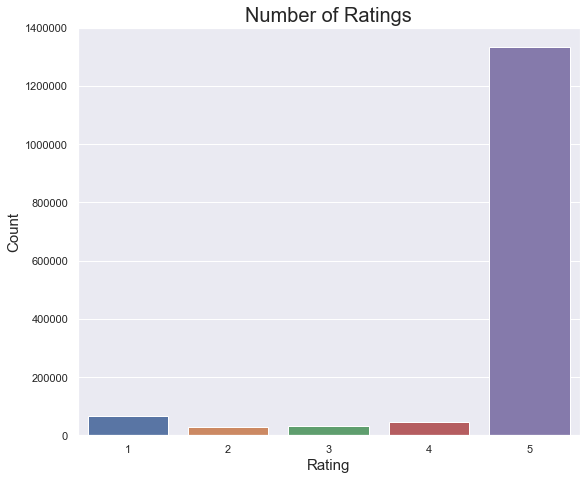

In [28]:
plot_barchart(rating, "Rating", "Count", "Number of Ratings")
plt.ticklabel_format(style="plain", axis="y")

Most reviews have a 5 star rating. However, these ratings may be biased to more extreme ratings as they only take into account the users who were willing to write a review. If this data included ratings that didn't write a review then they may be a lot more varied.

## Podcasts with most reviews

In [29]:
most_reviews = podcast_reviews["podcast_name"].value_counts().head(30)

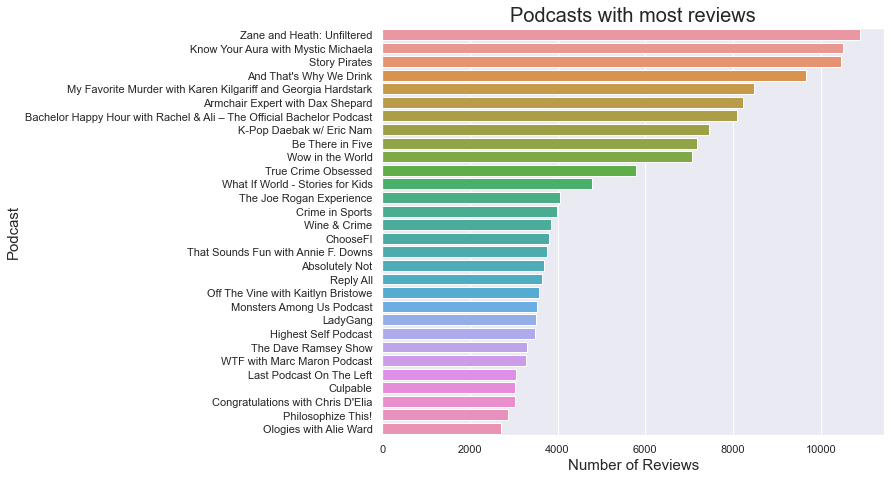

In [30]:
plot_barchart(
    most_reviews,
    "Podcast",
    "Number of Reviews",
    "Podcasts with most reviews",
    horizontal=True,
)

## Number of podcasts in each category

In [31]:
pod_category = category.groupby(["category"]).size().sort_values(ascending=False)

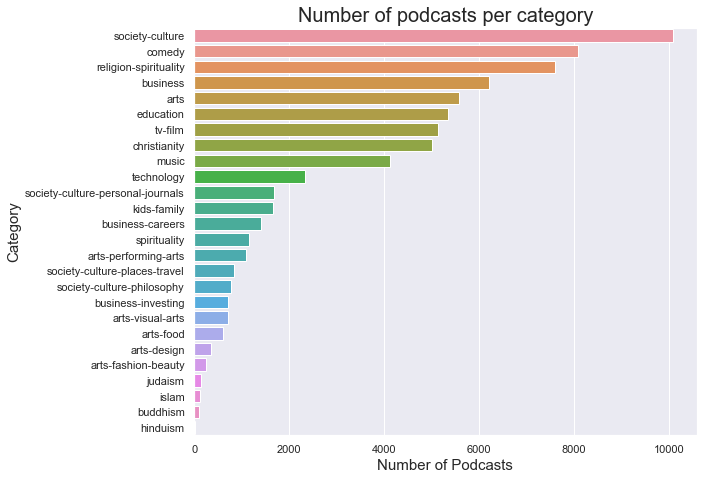

In [32]:
plot_barchart(
    pod_category,
    "Category",
    "Number of Podcasts",
    "Number of podcasts per category",
    horizontal=True,
)

More specific categories have less podcasts, which is expected.

## Average Ratings for the Top 10 Categories

In [33]:
category_top_10 = podcast_reviews[
    podcast_reviews["category"].isin(pod_category.head(10).index)
]
mean_rating_per_category = category_top_10.groupby("category").mean().squeeze()

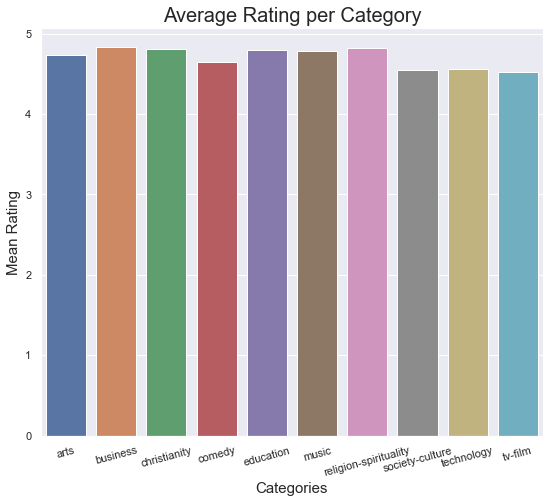

In [100]:
plot_barchart(
    mean_rating_per_category, "Categories", "Mean Rating", "Average Rating per Category"
)
plt.xticks(rotation=15)
plt.show()

## Monthly number of reviews

In [35]:
reviews_per_month = podcast_reviews.groupby(
    pd.Grouper(key="created_at", freq="M")
).size()

We'll drop the last row because the rest of the reviews for June 2021 haven't been uploaded yet.

In [36]:
reviews_per_month = reviews_per_month[:-1]

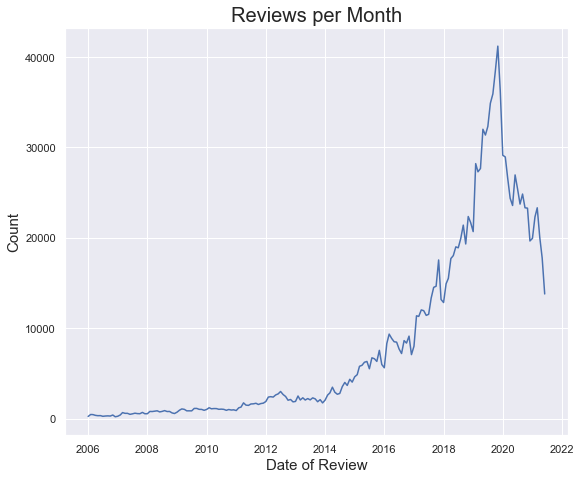

In [37]:
sns.lineplot(data=reviews_per_month)
plt.xlabel("Date of Review", size=15)
plt.ylabel("Count", size=15)
plt.title("Reviews per Month", size=20)
plt.show()

It is strange to see that the number of reviews began decreasing dramatically since the end of 2019. This could be for a number of reasons. For instance, this may be because the site has become better at detecting duplicate or bot reviews and has been removing them. Another possibility is that the overall popularity of Apple Podcasts has descreased, with users moving to other platforms such as Google Podcasts or Spotify.

# Is a listener significantly more likely to write a review if they give a podcast a 5 star rating?

Ideally, I would like to make inferences about the population of all ratings, not just those with reviews. However this may not be viable with the dataset we have availble. For instance, people who rate 1 star or 5 stars could be more likely to write a review about their experience. If this was the case, this dataset of review ratings would be biased and therefore not valid to make inferences about the ratings without reviews. So the dataset we currently have is a population.

Now looking back at the 'Reviews per Month' graph above, is it possible that the number of reviews is decreasing because it correlates with the number of 5 star ratings? If this was true, then from the end of 2019 onwards, the average rating has dropped significantly compared to previous years, resulting in less reviews.

Let's look at the average rating per month around this time (end of 2019):

In [38]:
start_date = "2019-10-31"

In [39]:
rating_per_month = podcast_reviews.groupby(
    pd.Grouper(key="created_at", freq="M")
).mean()

Now I'll add these to a new DataFrame

In [40]:
rating_per_month = rating_per_month[rating_per_month.index >= start_date][:-1]
reviews_per_month = reviews_per_month[reviews_per_month.index >= start_date]

rating_review_count = pd.DataFrame()

rating_review_count["created_at"] = reviews_per_month.index
rating_review_count["reviews_per_month"] = reviews_per_month.values
rating_review_count["rating_per_month"] = rating_per_month.values

In [41]:
rating_review_count.corr()

,reviews_per_month,rating_per_month
reviews_per_month,1.000000,0.867374
rating_per_month,0.867374,1.000000


Text(0, 0.5, 'Average Rating')

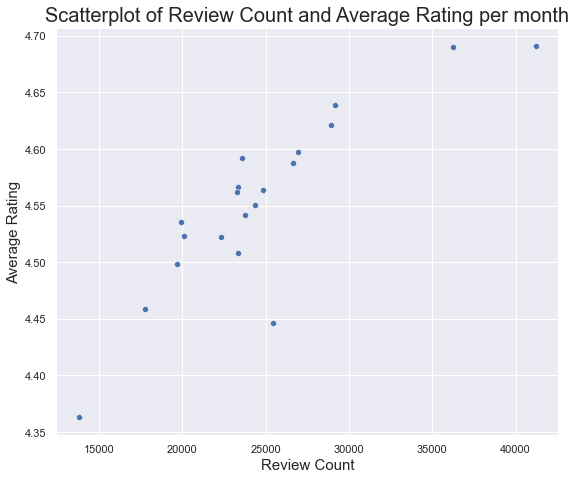

In [42]:
sns.scatterplot(
    x=rating_review_count["reviews_per_month"],
    y=rating_review_count["rating_per_month"],
)
plt.title("Scatterplot of Review Count and Average Rating per month", size=20)
plt.xlabel("Review Count", size=15)
plt.ylabel("Average Rating", size=15)

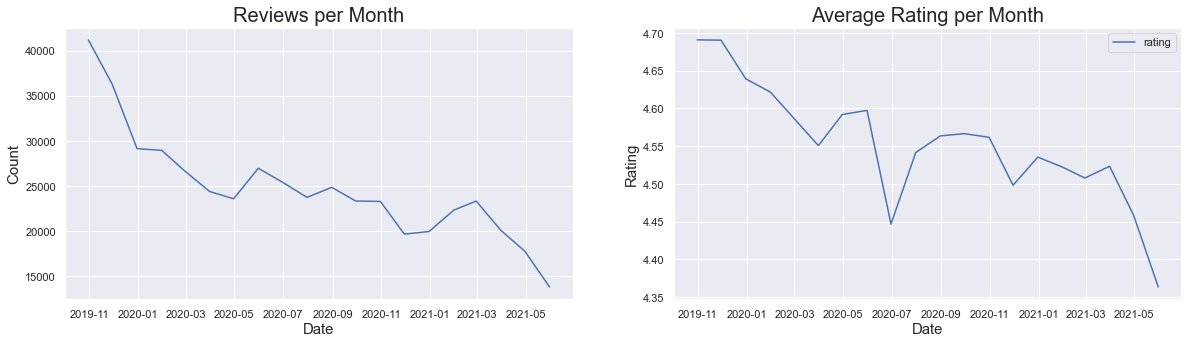

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.lineplot(data=reviews_per_month, ax=ax[0])
ax[0].set_xlabel("Date", size=15)
ax[0].set_ylabel("Count", size=15)
ax[0].set_title("Reviews per Month", size=20)

sns.lineplot(data=rating_per_month, ax=ax[1])
ax[1].set_xlabel("Date", size=15)
ax[1].set_ylabel("Rating", size=15)
ax[1].set_title("Average Rating per Month", size=20)

plt.show()

This shows that over the past 2 years, there have been less 5 star ratings, resulting in less reviews.

# Statistical Inference

These Hypothesis Tests and Confidence Intervals aren't necessary to calculate since we already have the population mean, they're just for demonstration

## What proportion of US Itunes Podcast Reviews in 2006-2021 belong in the Comedy category?

Estimating the Population Proportion:

In [44]:
sample_size = len(podcast_reviews)
comedy_category = (podcast_reviews["category"] == "comedy").sum()
best_point_est = comedy_category / sample_size
best_point_est

0.16422865221702262

16.42% of Itunes Podcast Reviews from 2006 to 2021 were in the Comedy category.

Compute Estimated Standard Error

In [45]:
standard_err = math.sqrt(best_point_est * (1 - best_point_est) / sample_size)
standard_err

0.0003021205307759377

Form a 95% Confidence Interval

In [46]:
lower_lim = best_point_est - 1.96 * standard_err
upper_lim = best_point_est + 1.96 * standard_err

print(f"[{lower_lim:.4f}, {upper_lim:.4f}]")

[0.1636, 0.1648]


The huge sample size means there isn't much leeway in the confidence interval

## Considering US Apple Podcast reviews between 2006-2021, did the categories 'music' and 'technology' have a significantly different mean rating?

- H0: music_mean - tech_mean == 0
- H1: music_mean - tech_mean != 0

We'll use a two-tailed z test with a signficiance value of 5%.

In [98]:
music = podcast_reviews[podcast_reviews["category"] == "music"]["rating"]
tech = podcast_reviews[podcast_reviews["category"] == "technology"]["rating"]

In [95]:
stests.ztest(music, tech, alternative="two-sided", usevar="pooled", ddof=1.0)

(33.916552387750684, 3.7985467047083074e-252)

The test statistic of 33.92 is extremely large. Let's have a look at what the actual means are:

In [99]:
[music.mean(), tech.mean()]

[4.787682450985115, 4.556647114912306]

Even though they may seem close, the sample size is so big that it would be impossible to see these categories having the same mean rating (as the p value above shows!).

# Conclusion

We found some interesting insights from this data, like how most ratings are 5 starts, and a trend that listeners who rate 5 stars are more likely to write a review. However, this discovery also lead to us not being able to accurately estimate properties of the overall ratings of podcasts. It would be interesting if we could use the data of all user ratings to confirm if this hypothesis is true.